In [1]:
import sys
print(sys.version)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
import cartopy.crs as ccrs
from datetime import datetime, timedelta


3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]


In [2]:
def center_time(DS1):
    """center_time(DS1)
    
    for E3SM and CESM monthly averaged files
    correct the time coordinate in an xarray object (DS1) to represent the center of the time bounds
 
    """
    DS = DS1.copy()
    # the time coord is often registered at the end of the time averaging interval
    # reset to the midpoint of the interval
    time = DS['time'].copy()
    bndname = time.attrs['bounds']
    time_bnds = DS1[bndname]
    tbdims = time_bnds.dims
    tbd_name = ''
    # find the bounds name (the dim that isn't time)
    for tbd in tbdims:
        if tbd != 'time':
            tbd_name = tbd
    # if no bounds, then do nothing
    if tbd_name == '':
        return DS
    else:
        tbm = time_bnds.mean(dim=tbd_name).values
        DS.coords["time"] = tbm
        DS['time'].attrs['long_name'] = 'time'
        DS['time'].attrs['bounds'] = 'time_bnds'
        return DS

In [3]:
def make_AA_tser(Var):
    ''' make Annual Averages from xarray objects (datasets or variables)
        Var: Xarray object
        returns object with annual averages (units are 'year')
    '''
    month_length = Var.time.dt.days_in_month
    twgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    V1AY = (Var*month_length).groupby("time.year").sum()/month_length.groupby("time.year").sum()
    # groupby loses the name attribute, so replace it for Xarray Variables, but not for DataSets
    thekeys = Var.attrs.keys()
    if 'name' in thekeys:
        #print('name exists',Var.name)
        V1AY = V1AY.rename(Var.name)
    return V1AY

In [4]:
def interp_ap(xt, yt, data2d,lat,lon,method=None):
    """
    # interp an arbitrary set of points at xt, yt 
    # from data on an unstructured mesh at lat, lon
    #
    # interpolating in lat/lon space has issues with triangulation 
    # at pole and wrapping at greenwich, so interpolate in stereographic projection:
    #
    # input:
    #    data2d(ncol,...),lat(ncol),lon(ncol): data and coords on unstructured mesh
    #    data2d can be multidimensional array, but ncol must be first coordinate
    #    xt, yt: lat and lon coordinates of locations to interpolate to
    #    method: optional, use cubic interpolation if method='cubic'
    #
    # output 
    #    returns an array with same shape as xt with interpolated data
    #
    """
    from scipy.interpolate import LinearNDInterpolator
    from scipy.interpolate import CloughTocher2DInterpolator
    
    intp2D = LinearNDInterpolator
    if method == 'cubic':
        intp2D = CloughTocher2DInterpolator

    ld = data2d.shape[0] # length of first coord of input data
    lx = lon.shape[0]
    ly = lat.shape[0]
    if ((ld != lx) | (ld != ly)):
        print('inconsistent data2d, lon, lat arrays', ld, lx, ly)
        raise TypeError("inconsistent input in interp_ap")
    
    # mesh grid
    dproj=ccrs.PlateCarree()

    # select interpolation points located in the nh and sh
    inds = np.where(yt <= 0)
    indn = np.where(yt > 0)

    xtn = xt[indn]
    ytn = yt[indn]
    xts = xt[inds]
    yts = yt[inds]

    # take source data in the correct hemisphere, include extra halo points for interpolation
    # using the full global data sometimes confuses interpolation with points being mapped close to infinity
    halo = 15 # degrees
    data2d_h=data2d[lat<halo]

    lon_h=lon[lat<halo]
    lat_h=lat[lat<halo]
    coords_in  = ccrs.SouthPolarStereo().transform_points(dproj,lon_h,lat_h)

    dims = list(xt.shape)+list(data2d[0,...].shape)

    data_i = np.zeros(dims,dtype=data2d.dtype)
    data_i[:] = np.nan

    data_s = []
    if len(yts) > 0:
        cto = ccrs.SouthPolarStereo().transform_points(dproj,xts,yts)
        interp = intp2D(coords_in[:,0:2], data2d_h)
        data_s = interp(cto[:,0],cto[:,1])
        data_i[inds] = data_s

    data2d_h=data2d[lat>-halo]
    lon_h=lon[lat>-halo]
    lat_h=lat[lat>-halo]
    coords_in  = ccrs.NorthPolarStereo().transform_points(dproj,lon_h,lat_h)

    data_n = []
    if len(ytn) > 0:
        cto = ccrs.NorthPolarStereo().transform_points(dproj,xtn,ytn)
        interp = intp2D(coords_in[:,0:2], data2d_h)
        data_n = interp(cto[:,0],cto[:,1])
        data_i[indn] = data_n

    return data_i

In [5]:
# get the data on cubed sphere grid

# some of Haruki's datasets dont have lat/lon/area, so grab that data
ne30area = '~jupyter-adminphil/NetCDF_Files/ne30pg2.nc'
DSA = xr.open_mfdataset(ne30area)
lon_cs = DSA.lon
lat_cs = DSA.lat
area_cs = DSA.area

# grab a timeseries file
ind_ptb = '/e3sm_prod/phil/timeseries/e3sm-reshaped/20231122.v2.LR.WCYCLSSP245.MCB-SSLT-EM.R1245.test01/PRECT_201501_*.nc'
DS1 = xr.open_mfdataset(ind_ptb)

# correct the time coordinate so slicing works
DS1 = center_time(DS1)

# slice an interval
DS1 = DS1.sel(time=slice("2020-01-01","2030-01-01"))

# convert monthly time series to annual avgs (handles leap years, different length months etc)
DS1 = make_AA_tser(DS1)

Varname = 'PRECT'
# average the years
V1 = DS1[Varname].mean('year')

In [6]:
# map data to lat/lon grid

dinc = 1.  # increment of mesh in degrees
lon_ll=np.arange(0.,361, dinc)
lat_ll=np.arange(-90.,90.,dinc)
xoutm,youtm=np.meshgrid(lon_ll,lat_ll)

Vnew1 = xr.DataArray(interp_ap(xoutm, youtm, V1.values,lat_cs.values,lon_cs.values), 
                    coords={'lat': lat_ll,'lon': lon_ll}, #,'lev': Var_e3sm.lev.values},
                    attrs=V1.attrs,
                    dims=["lat", "lon"]) #,"lev"])

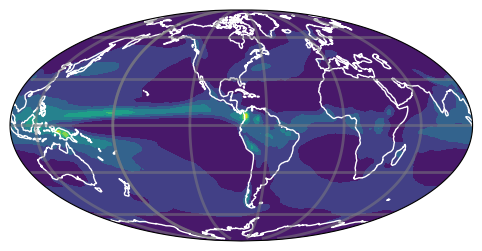

In [7]:
# plot it

plotproj = ccrs.Mollweide(central_longitude=-80)
plotproj._threshold /= 100.
fig, axes = plt.subplots(ncols=1,nrows=1,
                         #gridspec_kw={'width_ratios': [1]},
                         subplot_kw={'projection': plotproj},
                         figsize=(8.,3.0),
                        )

pl = axes.contourf(Vnew1.lon.values, Vnew1.lat.values, Vnew1.values, 
                 transform=ccrs.PlateCarree())

gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5)
axes.coastlines(linewidth=1,color='white')